# GEOG5995M Final Assignment
# Air Quality and Deprivation: Liverpool City Region

Student ID number: 201800475

In the pursuit of creating healthier and more equitable urban environments, the intersection of air quality and socioeconomic deprivation emerges as a critical focal point for exploration. The quality of the air we breathe is an essential determinant of public health, influencing the well-being of individuals and communities alike. Simultaneously, the distribution of air pollution and its impacts often reflect and exacerbate existing socioeconomic disparities within a city. This exploration seeks to unravel the intricate relationship between air quality and deprivation, delving into how environmental conditions can be shaped by and, in turn, influence the social and economic fabric of urban communities.

In [2]:
# import all the necessary packages for the script to run
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import esda
import spreg
import numpy as np
import libpysal
from scipy.stats import pearsonr, linregress

## Data Cleaning

In [3]:
# get the current directory where the script is located
current_directory = os.getcwd()
# change working directory to current directory 
os.chdir(current_directory)

# import data from csv files
shapefile = gpd.read_file('deprivation/shapefiles/E47000004.shp')
deprivationcsv = pd.read_csv('deprivation/tables/deprivation2019.csv')
ahahcsv = pd.read_csv('AHAH.csv')

# select only Liverpool City entries
deprivation_clean = deprivationcsv[deprivationcsv['lsoa11nm'].str.startswith('Liverpool')]

# merge 2 csv files into a dataframe
csvdf = pd.merge(deprivation_clean, ahahcsv, on='lsoa11cd')

# merge clean dataframe and shapefile
df = shapefile.merge(csvdf, on='lsoa11cd')

I have taken both datasets (Access to Healthy Assets & Hazards (2017) and Index of Multiple Deprivation (2019)) from the CDRC website <a href="https://data.cdrc.ac.uk/">[1]</a>. Firstly the script imports csv and shapefiles. Then from the deprivation csv we select only entries that are relevant to Liverpool City area and merge the entries with the AHAH csv in order to get a combined csv file. Finally we merge csv and shapefile into a single dataframe. 

## Data Exploration and Visualisation

In [16]:
# convert variables into an array
deprivation = np.array(df['IMDScore'])
no2 = np.array(df['ah3no2'])
so2 = np.array(df['ah3so2'])
pm10 = np.array(df['ah3pm10'])

# explore max, min, average values in the dataframe
print(f'Max NO2: {max(no2):.2f}\tMax SO2: {max(so2):.2f}\tMax PM10: {max(pm10):.2f}\n')
print(f'Avg NO2: {np.average(no2):.2f}\tAvg SO2: {np.average(so2):.2f}\tAvg PM10: {np.average(pm10):.2f}\n')
print(f'Min NO2: {min(no2):.2f}\tMin SO2: {min(so2):.2f}\tMin PM10: {min(pm10):.2f}\n')
print(f'Deprivation Score Range: {min(deprivation):.2f} - {max(deprivation):.2f}\n')

Max NO2: 27.38	Max SO2: 5.99	Max PM10: 15.09

Avg NO2: 17.53	Avg SO2: 2.73	Avg PM10: 13.35

Min NO2: 11.96	Min SO2: 1.87	Min PM10: 11.16

Deprivation Score Range: 3.94 - 84.37



WHO Reference (max permitted pollution levels): NO2 - 25; SO2 - 40; PM10 - 15
As we can see from our initial exploration air quality in Liverpool City area seems to fall within the safe boundaries established by the WHO, with exception of nitrous dioxide being slightly higher in some areas at 27ppm. Sulphur dioxide levels seem to be well within the safety limits. PM10 is in the range between 11 and 15 which is natural for cities as there is a lot of movement and traffic meaning that small particles will be present in the air most of the time.
As for the deprivation levels we can see that the range is very large, indicating that Liverpool, for it's size, has a considerable variation among neighbourhoods in terms of income, employment, education, crime, environment and other factors that make up the deprivation score. This shows a big divide within the city between those that have and have not. Next step would be to visualise pollution levels within the city limits in order to further our understanding of the spread of pollution and to see if some areas are more prone to it than others.

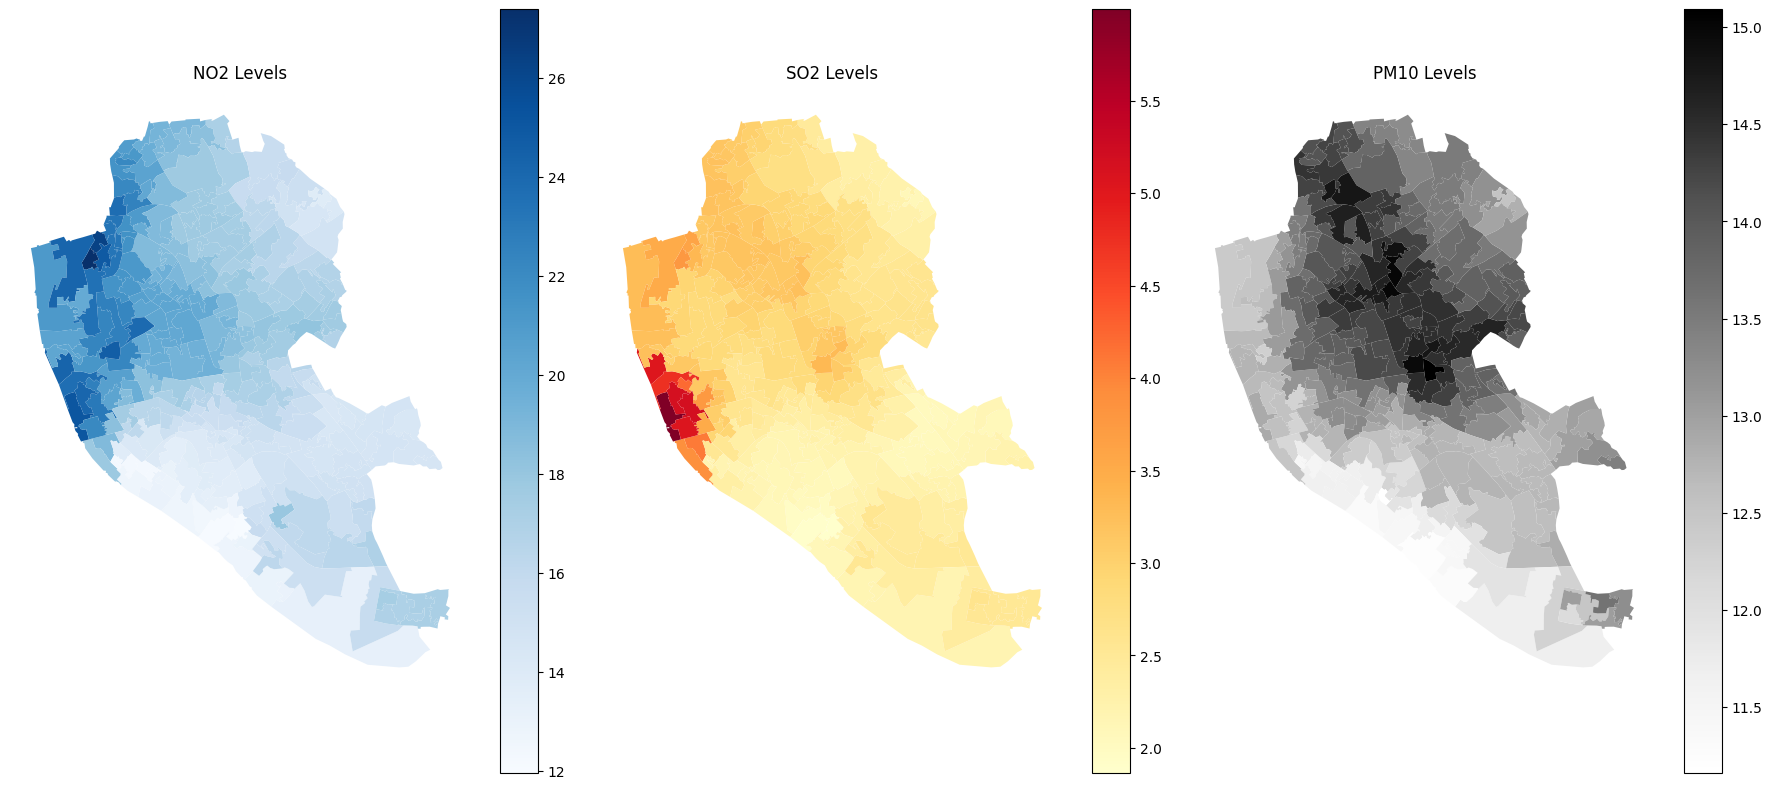

In [5]:
# create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18,8))

# create a map for NO2
df.plot(ax=axes[0], column=no2, legend=True, cmap='Blues')
axes[0].set_title('NO2 Levels')
axes[0].set_axis_off()

# create a map for SO2
df.plot(ax=axes[1], column=so2, legend=True, cmap='YlOrRd')
axes[1].set_title('SO2 Levels')
axes[1].set_axis_off()

# create a map for PM10
df.plot(ax=axes[2], column=pm10, legend=True, cmap='Greys')
axes[2].set_title('PM10 Levels')
axes[2].set_axis_off()

# adjust the layout and show the figure
plt.tight_layout()
plt.show()

Following our numeric analysis we have produced visual maps which show the concentration of different pollutants across the city region. Visualising pollutant levels shown us that there is a geographical patters to the spread and intensity of pollutants. In order to understand this we first need to consider the wind direction patterns in Liverpool. As we can see from <a href="https://weatherspark.com/y/39878/average-Weather-in-Liverpool-United-Kingdom-Year-Round#Figures-WindDirection">[2]</a>, Liverpool predominantly experiences wind from the west and south, making up between 60%-78% of all the wind direction on any given day. From this we can hypothesise that northern parts of Liverpool will have higher levels of pollution which is exactly what we see from the visualisations. Nitrous dioxide levels tend to concentrate in the north western area, mainly where Liverpool's docks, businesses and industrial estates are located. This aligns with information about nitrous dioxide, as noted by US Environmental Protection Agency: The source of NO2 in the air is mainly from burning fuel. <a href="https://www.epa.gov/no2-pollution/basic-information-about-no2">[3]</a> If we add wind direction into consideration, pollution that is created by traffic to the city centre will be carried north and north-east most of the time. This effect can also be seen from the map depicting PM10 concentrations which lie predominantly in the northern and north-eastern parts of the city. In contrast, sulphur dioxide pollution levels are concentrated around Liverpool city centre, where traffic levels are always high. SO2 particles mainly arise from the burning of fossil fuels, whether it is traffic, ships or industry <a href="https://www.epa.gov/so2-pollution">[4]</a>. However, concentrations of SO2 in the city centre are well below the WHO limit.

### Moran's I

In [17]:
# MORAN'S I weight matrix from the dataframe
w = libpysal.weights.Queen.from_dataframe(df, use_index=True)

# calculate Moran's I for Nitrous Dioxide
moran = esda.Moran(no2, w)
print(f'NO2 Moran\'s I: {moran.I:.3f}, p-value: {moran.p_sim}')

# calculate Moran's I for Sulphur Dioxide
moran = esda.Moran(so2, w)
print(f'SO2 Moran\'s I: {moran.I:.3f}, p-value: {moran.p_sim}')

# calculate Moran's I for Particulate Matter 10 microns or less
moran = esda.Moran(pm10, w)
print(f'PM10 Moran\'s I: {moran.I:.3f}, p-value: {moran.p_sim}')

# calculate Moran's I for Deprivation
moran = esda.Moran(deprivation, w)
print(f'Deprivation Moran\'s I: {moran.I:.3f}, p-value: {moran.p_sim}')

NO2 Moran's I: 0.903, p-value: 0.001
SO2 Moran's I: 0.826, p-value: 0.001
PM10 Moran's I: 0.919, p-value: 0.001
Deprivation Moran's I: 0.690, p-value: 0.001


Moran's I is a statistical measure used to assess spatial autocorrelation in a dataset. Spatial autocorrelation refers to the degree to which the values of a variable are correlated with the values of the same variable in neighboring locations. Moran's I helps identify whether there is a spatial pattern of similarity or dissimilarity in the distribution of values across a geographic area. Values closer to 1 indicate that positive spacial correlation exists. From the analysis we can see that NO2 and PM10 have Moran's I > 0.9 which indicates very strong correlation. Sulphur pollution has a value of 0.82 and deprivation a value of 0.69. Deprived areas are present across different locations in the city and can be close to more affluent areas, hence we get a reduced value. The value would be higher if we had a symmetrical distribution of deprivation across the city (deprived north vs affluent south).

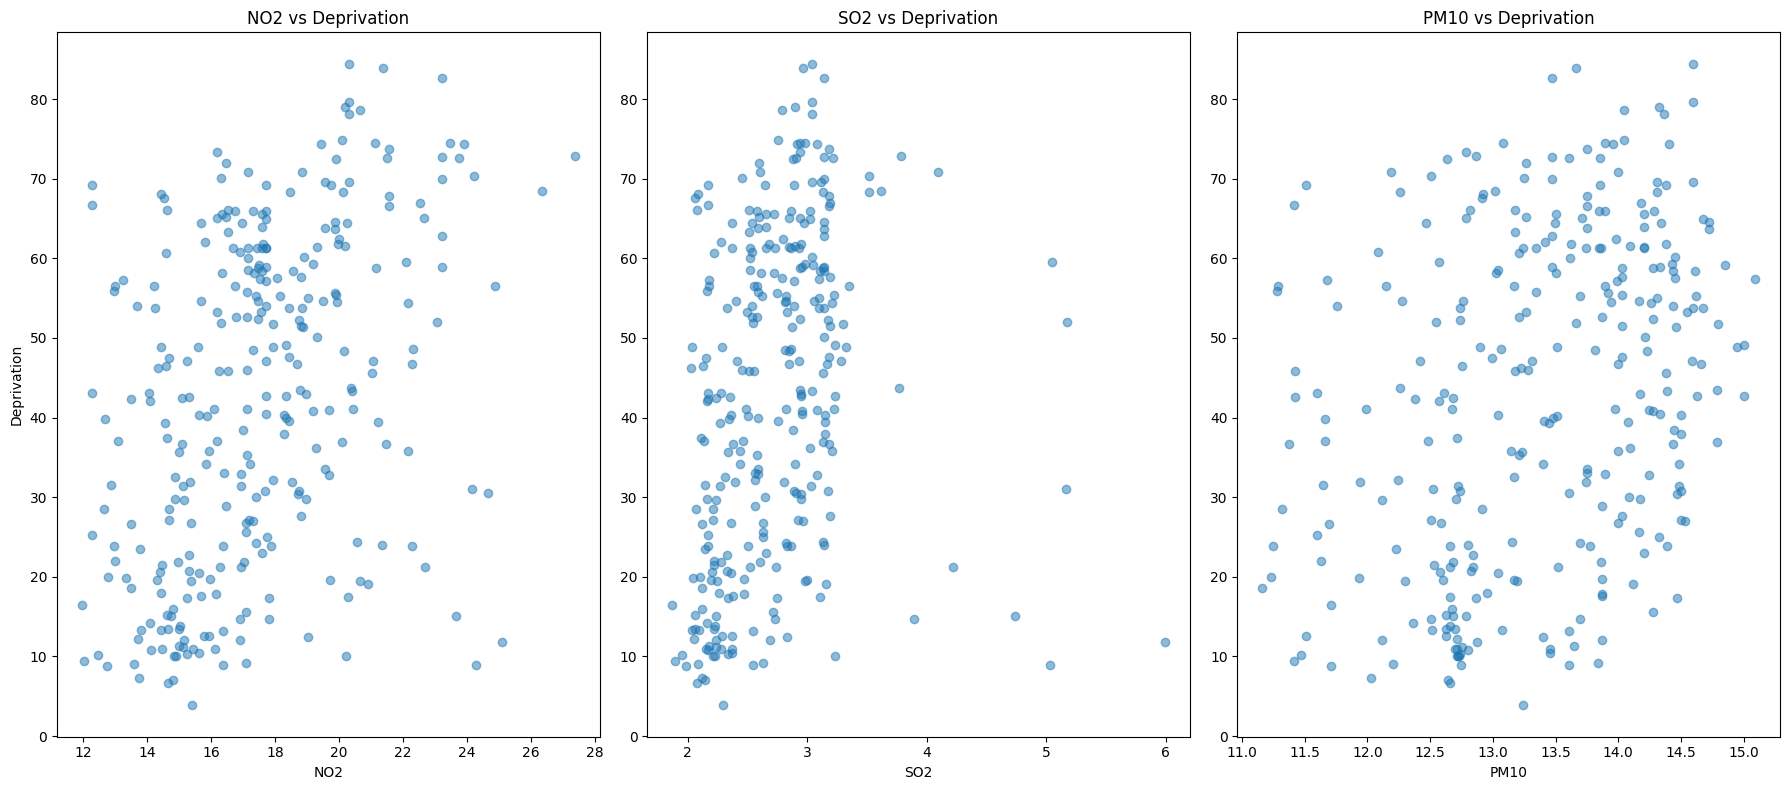

In [6]:
# create separate scatter plots for each independent variable vs. Deprivation
plt.figure(figsize=(18, 8))

# plot for NO2 vs. Deprivation
plt.subplot(131)  # 1 row, 3 columns, 1st plot
plt.scatter(no2, deprivation, alpha=0.5)
plt.title('NO2 vs Deprivation')
plt.xlabel('NO2')
plt.ylabel('Deprivation')

# plot for SO2 vs. Deprivation
plt.subplot(132)  # 1 row, 3 columns, 2nd plot
plt.scatter(so2, deprivation, alpha=0.5)
plt.title('SO2 vs Deprivation')
plt.xlabel('SO2')

# plot for PM10 vs. Deprivation
plt.subplot(133)  # 1 row, 3 columns, 3rd plot
plt.scatter(pm10, deprivation, alpha=0.5)
plt.title('PM10 vs Deprivation')
plt.xlabel('PM10')

# show the plot
plt.tight_layout()
plt.show()

From looking at the scatterplots no obvious patterns emerge in the relationship between pollutants and deprivation levels. In order to analyse this further  we will need to fit our data to a regression model.

### Linear Regression

In [42]:
# define WHO standards (maximum allowable concentrations) for each pollutant
no2_standard = 25
so2_standard = 40
pm10_standard = 15

# calculate individual sub-indices for each pollutant
index_no2 = (no2 / no2_standard) * 100
index_so2 = (so2 / so2_standard) * 100
index_pm10 = (pm10 / pm10_standard) * 100

# calculate the AQI (air quality index) as the maximum of the sub-indices
aqi = np.max(np.array([index_no2, index_so2, index_pm10]), axis=0)

# calculate Pearson correlation
pearson_correlation, _ = pearsonr(aqi, deprivation)

print(f'Pearson Correlation: {pearson_correlation:.4f}\n')

# perform simple linear regression
slope, intercept, r_value, p_value, std_err = linregress(aqi, deprivation)



# print regression results
print('AQI vs Deprivation Regression Results')
print(f'Slope (Coefficient): {slope:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'p-value: {p_value}')

Pearson Correlation: 0.3462

AQI vs Deprivation Regression Results
Slope (Coefficient): 1.1042
Intercept: -56.4154
R-squared: 0.1198
p-value: 8.179250742590851e-10


In order to standardise air quality we have created an air quality index (AQI). AQI is the maximum value from all the pollutants present in an area, so if an area has the highest polluting index coming from NO2 then NO2 value will be chosen. 
The result for pearson correlation is 0.35, which suggests that a moderate positive correlation exist between AQI and deprivation. A linear regression model has an r-squared value of 0.12 which is quite low as it indicates that the model can only explain around 12% of data with the other 78% possibly arising by chance alone. 
These results show that maybe assuming lineliarity between the variables is misleading so next step would be to perform geographically weighted regression which takes space into account when modelling.

### Geographically Weighted Regression

In [55]:
# create a weights matrix for geographically weighted regression
w = libpysal.weights.Queen.from_dataframe(df, use_index=True)

# create a multidimensional array for pollution and transpose it so each row represents a data point
pollution = np.array([no2, so2, pm10]).T

# create a geographically weighted regression model
model = spreg.OLS(y=deprivation, x=pollution, w=w, name_y='Deprivation', name_x=['NO2', 'SO2', 'PM10'])
results = model.output

# view regression results
print(results)

  var_names coefficients    std_err   zt_stat      prob
0  CONSTANT    -45.78614  15.734838 -2.909858  0.003892
1       NO2     3.021181   0.652824  4.627866  0.000006
2       SO2      -5.4221   3.286116 -1.650002   0.10001
3      PM10     3.756899   1.339548  2.804602  0.005373


Results from geographically weighted regression show that NO2 and PM10 are correlated with deprivation levels (p-values < 0.005). SO2 p-value is 0.1 which means that the result is not statistically significant, which is understandable since SO2 pollution is mainly centered around city centre.

### LISA Clustering

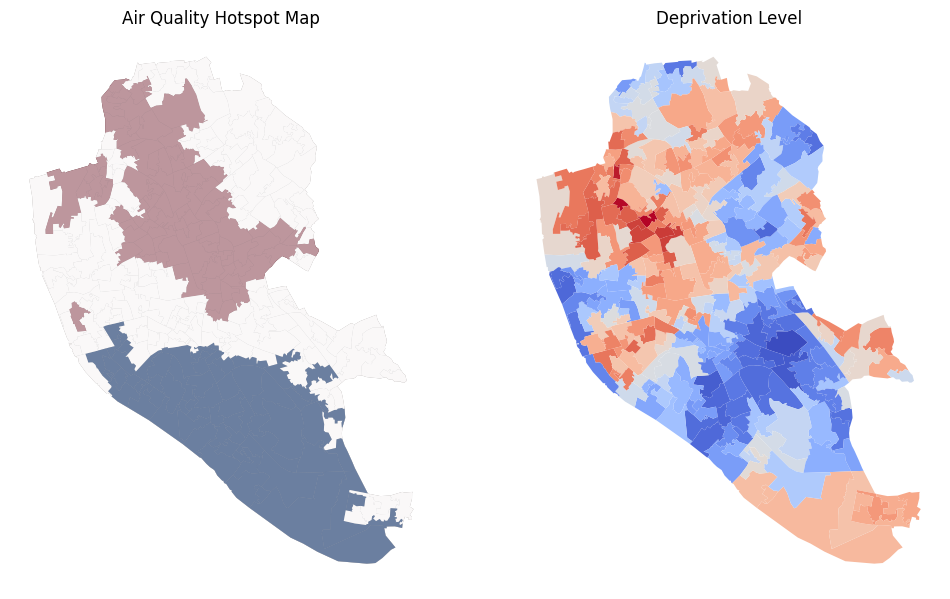

In [13]:
# calculate Local Moran's I
lisa = esda.Moran_Local(aqi, w)
lisa_cluster = lisa.q

# create a new column in the dataframe to store the LISA cluster information
df['LISA_CLUSTER'] = lisa_cluster

# create a LISA significance map
lisa_significance = lisa.p_sim < 0.05  # You can adjust the significance level as needed

# create a LISA hotspot map
lisa_hotspots = (lisa_cluster == 1) & lisa_significance
lisa_coldspots = (lisa_cluster == 3) & lisa_significance  # adjust for low-low clusters

# create new columns in the dataframe to store the hotspot and coldspot information
df['LISA_HOTSPOT'] = lisa_hotspots
df['LISA_COLDSPOT'] = lisa_coldspots

# plot the hotspot map and deprivation map side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
df.plot(ax=axes[0], color='grey')
df.plot(ax=axes[0], column='LISA_HOTSPOT', cmap='Reds', alpha=1)
df.plot(ax=axes[0], column='LISA_COLDSPOT', cmap='Blues', alpha=0.6)
axes[0].set_title('Air Quality Hotspot Map')
axes[0].set_axis_off()

df.plot(deprivation, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Deprivation Level')
axes[1].set_axis_off()

plt.show()

LISA, which stands for Local Indicators of Spatial Association, is a statistical method used to identify and analyze spatial clusters in a dataset. LISA clustering specifically focuses on assessing whether individual locations exhibit similar or dissimilar values compared to their neighboring locations. As can be seen from the visualisation, Liverpool has a hotspot for air pollution in the north of the city and a coldspot in the south. Equally a visualisation for deprivation shows that northern neihgbourhoods have higher deprivation scores than the south, with some variation present. In order to understand which neighbouhoods of Liverpool have high pollution levels and deprivation a combined map needs to be produced.

## Data Visualisation

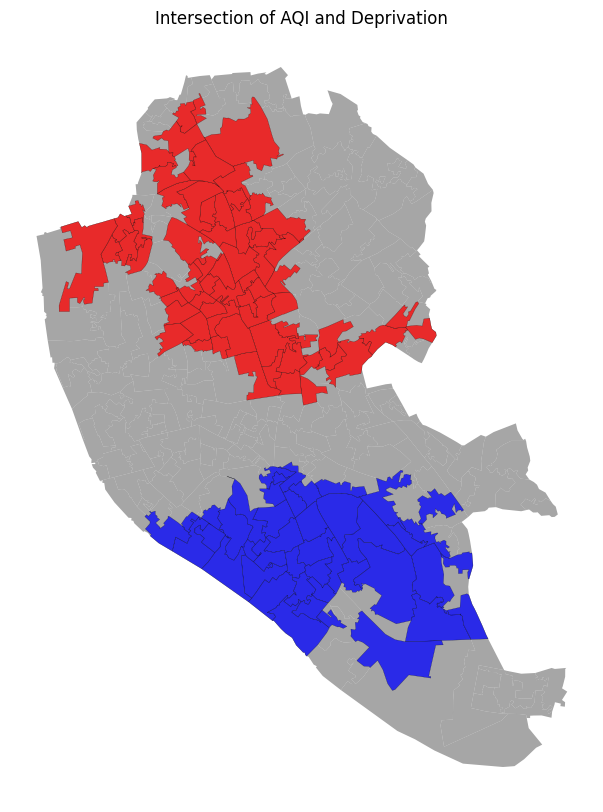

In [21]:
# LISA clusters and deprivation dataframe combination
hotspot_df = df[(lisa_hotspots) & (deprivation > 40)]
coldspot_df = df[(lisa_coldspots) & (deprivation < 40)]

# Plot the filtered map
fig, axes = plt.subplots(figsize=(10, 10))
df.plot(ax=axes, color='grey', alpha=0.7)
hotspot_df.plot(ax=axes, color='red', edgecolor='black', linewidth=0.2, alpha=0.75)
coldspot_df.plot(ax=axes, color='blue', edgecolor='black', linewidth=0.2, alpha=0.75)
axes.set_title('Intersection of AQI and Deprivation')
axes.set_axis_off()

plt.show()

Here is that map. Hotspots were defined as areas from LISA clustering with high pollution index and index of multiple deprivation score > 40. Coldspots are areas with low pollution and IMD score < 40. As we can see from the map there are areas of northern Liverpool which have the hotspot characteristics. These neighbourhoods would require greated involvement from the authorities be it in terms of tackling deprivation or air pollution. Identifying those areas is the first step in successful policy development. 

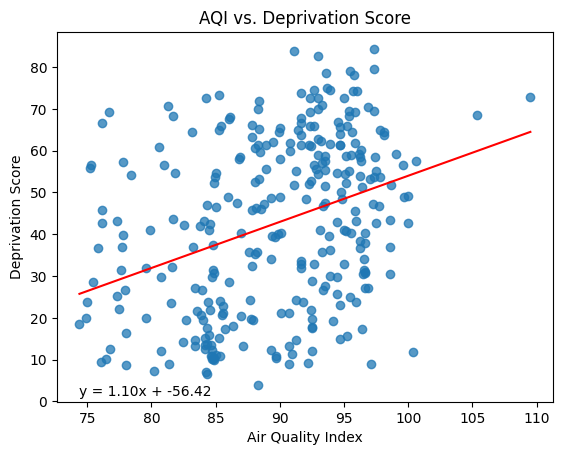

In [41]:
# create a regression line
x_range = np.linspace(min(aqi), max(aqi))
regression_line = slope * x_range + intercept

# visualise data on a scatter plot
plt.plot(x_range, regression_line, color='red')
plt.scatter(aqi, deprivation, alpha=0.75)
plt.text(min(aqi), min(deprivation), f'y = {slope:.2f}x + {intercept:.2f}', color='black', verticalalignment='top', horizontalalignment='left')
plt.xlabel("Air Quality Index")
plt.ylabel("Deprivation Score")
plt.title("AQI vs. Deprivation Score")
plt.show()

The scatterplot shows the relationship between AQI and deprivation. There are only a couple of datapoints with an AQI > 100, which is good news as it means that most areas of Liverpool have pollution levels within the WHO recommended guideline. A linear regression line shows that an increase in air quality index generally results in higher deprivation scores.

## References

<p><a href="https://data.cdrc.ac.uk/">[1]</a>CDRC Website</p>
<p><a href="https://weatherspark.com/y/39878/Average-Weather-in-Liverpool-United-Kingdom-Year-Round#Figures-WindDirection">[2]</a>Wind Direction</p>
<p><a href="https://www.epa.gov/no2-pollution/basic-information-about-no2">[3]</a>US EPA SO2</p>
<p><a href="https://www.epa.gov/so2-pollution">[4]</a>US EPA NO2</p>